# Sync

In [ ]:
!aws s3 sync  resources/grn_benchmark/ s3://openproblems-data/resources/grn/grn_benchmark/ --delete


upload: resources/grn_benchmark/evaluation_data/norman_bulk.h5ad to s3://openproblems-data/resources/grn/grn_benchmark/evaluation_data/norman_bulk.h5ad
upload: resources/grn_benchmark/evaluation_data/adamson_bulk.h5ad to s3://openproblems-data/resources/grn/grn_benchmark/evaluation_data/adamson_bulk.h5ad
upload: resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad to s3://openproblems-data/resources/grn/grn_benchmark/evaluation_data/nakatake_bulk.h5ad
upload: resources/grn_benchmark/evaluation_data/replogle_bulk.h5ad to s3://openproblems-data/resources/grn/grn_benchmark/evaluation_data/replogle_bulk.h5ad
upload: resources/grn_benchmark/inference_data/nakatake_rna.h5ad to s3://openproblems-data/resources/grn/grn_benchmark/inference_data/nakatake_rna.h5ad


# Import

In [1]:
%reload_ext autoreload
%autoreload 2
import yaml
import os
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import sys 
import subprocess
import io
import warnings
from tqdm import tqdm

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sys.path.append('../')
from grn_benchmark.src.helper import surragate_names
from src.exp_analysis.helper import plot_cumulative_density

# from src.helper import *
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'figr','granie','negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'scenicplus'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores'
}

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

In [10]:
atac = ad.read_h5ad('resources_test/grn_benchmark/inference_data/op_atac.h5ad')

In [30]:
annotation_peak = atac.var.reset_index().location.str.split(':', expand=True)
atac.var['seqname'] = annotation_peak[0].values
atac.var['ranges'] = annotation_peak[1].values
atac.var['strand'] = '+'

atac.write('resources_test/grn_benchmark/inference_data/op_atac.h5ad')


In [31]:
atac.obs

,cell_type,donor_id
obs_id,,
GTCTTTAGTTAGTGAT-3,B cells,donor_0
TAATGCATCGAGGAGT-3,T cells,donor_0
TCTAGCACACTATGGC-3,T cells,donor_0
GCTAATATCGTCAAGT-3,Myeloid cells,donor_0
GTTACGTAGGTGCGGA-3,Myeloid cells,donor_0
...,...,...
TCATGAGGTTTGTTGC-3,Myeloid cells,donor_0
AAGTGAAGTCTTACTA-3,Myeloid cells,donor_0
ATACCTGCAGGAACTG-3,NK cells,donor_0


# Peregrn

In [37]:
adata = ad.read('resources/grn_benchmark/inference_data/norman_rna.h5ad')

In [16]:
# par = {
#     'adata_bulk': f'resources/extended_data/replogle_bulk.h5ad',
#     'adata_test_bulk': f'resources/grn_benchmark/evaluation_data/replogle_bulk.h5ad',
#     'adata_train_bulk': f'resources/grn_benchmark/inference_data/replogle_rna.h5ad'
# }

# for key, value in par.items():
    
#     data1 = ad.read_h5ad(value)
#     print(key, value, data1.shape, data1.obs['perturbation'].nunique())
#     sc.pp.pca(data1, layer='X_norm')
#     sc.pp.neighbors(data1, n_neighbors=10)
#     sc.tl.umap(data1)

#     sc.pl.umap(data1, wspace=0.3)
#     sc.pl.pca(data1, wspace=0.3)


In [27]:
from matplotlib.gridspec import GridSpec

def plot_heatmap(scores, ax=None, name='', fmt='0.02f', cmap="viridis"):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

    # Normalize each column individually
    scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
    scores_normalized = scores_normalized.round(2)
    # scores_normalized['Rank'] = scores['Rank'].max()-scores['Rank']
    # scores_normalized['Rank'] = scores_normalized['Rank']/scores_normalized['Rank'].max()

    # Define the color scale range for each column (0 to 1 after normalization)
    vmin = 0
    vmax = 1

    # Plot the heatmap with normalized scores
    seaborn.heatmap(scores_normalized, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax, cmap=cmap)
    # Overlay the original (unnormalized) scores as annotations
    # scores['Rank'] = scores['Rank'].astype(int)
    # print(scores['Rank'])
    # Overlay the original (unnormalized) scores as annotations
    for text, (i, j) in zip(ax.texts, np.ndindex(scores.shape)):
        value = scores.iloc[i, j]
        if isinstance(value, np.int64):  # Check if the value is an integer for 'Rank'
            text.set_text(f'{value:d}')
        else:
            text.set_text(f'{value:.2f}')

    # Customize the axes and title
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
    

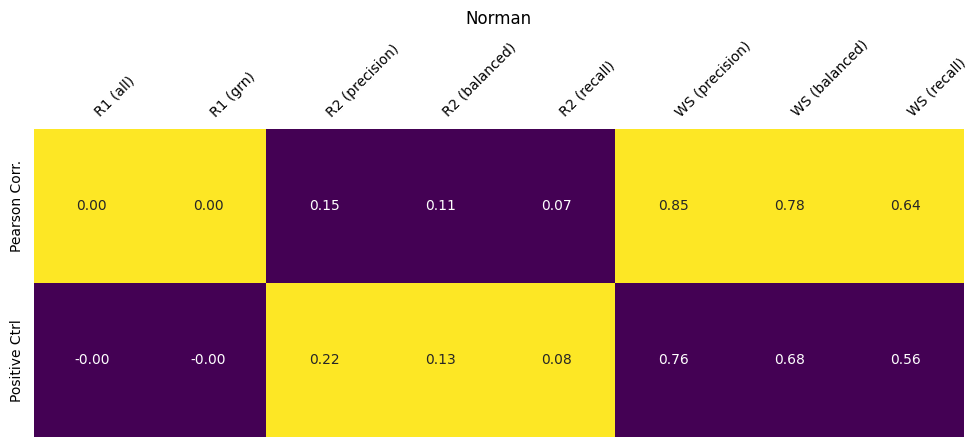

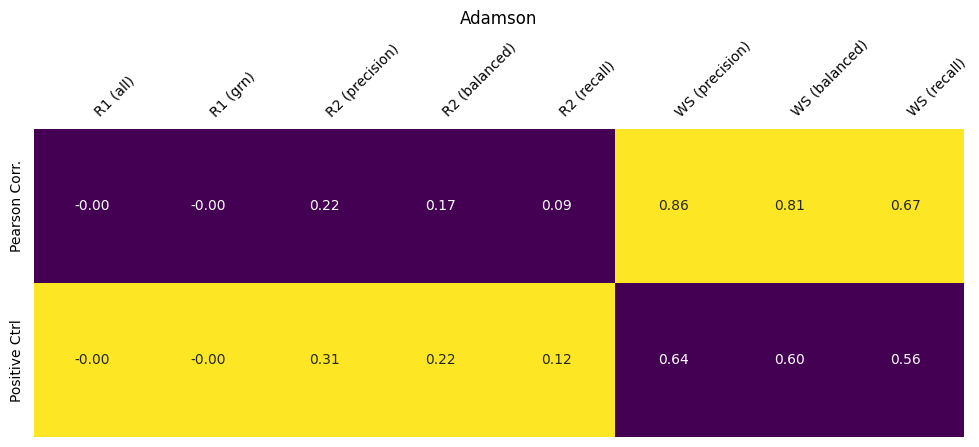

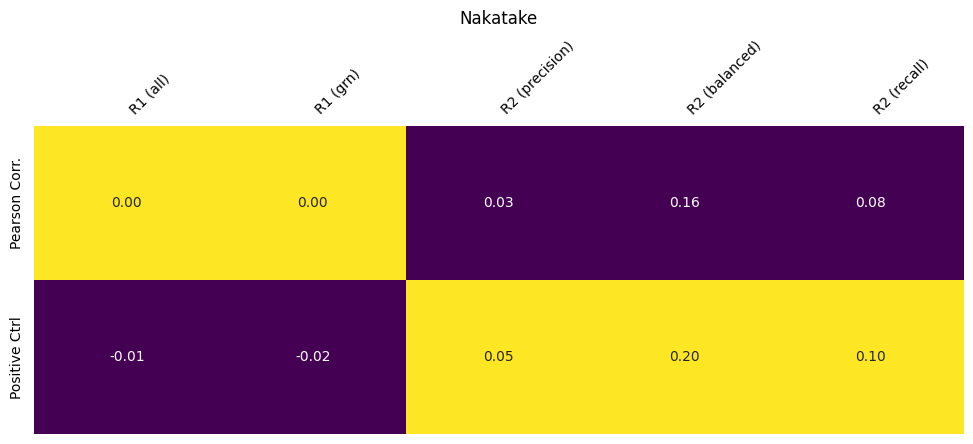

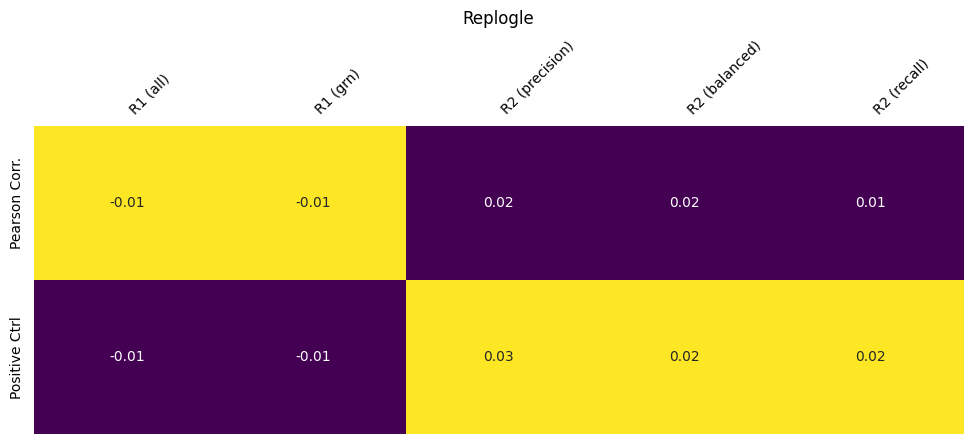

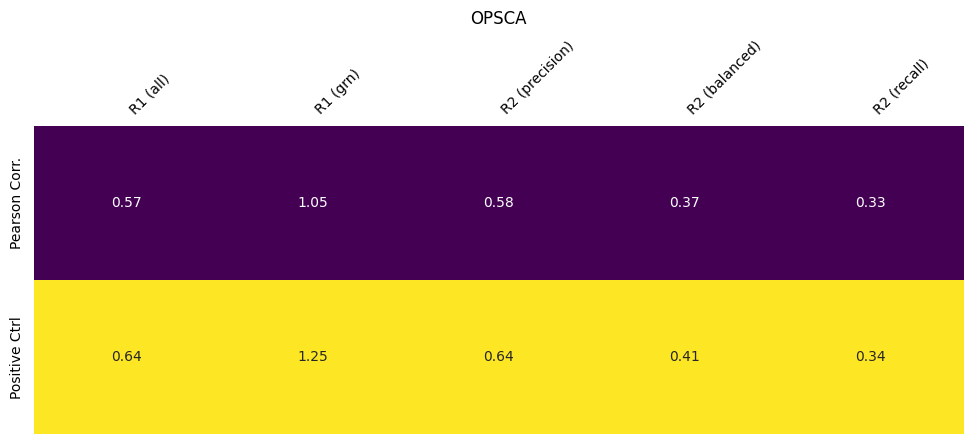

In [32]:
def plot_raw_scores(df_all, dataset, ax):
    scores_mat = df_all[df_all['dataset'] == dataset].set_index('model').drop(columns='dataset')
    
    # Remove rows where all values are NaN
    scores_mat = scores_mat.dropna(how='all', axis=1)

    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)

    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    
    ax.set_title(surragate_names.get(dataset, dataset), pad=10, fontsize=12)
    ax.set_ylabel('')
df_all =pd.read_csv("resources/scores/scores_controls.csv", index_col=0).reset_index().rename(columns={'index': 'model'})
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_raw_scores(df_all, 'norman', ax)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_raw_scores(df_all, 'adamson', ax)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_raw_scores(df_all, 'nakatake', ax)
# ax.set_yticklabels([])
plt.subplots_adjust(wspace=.4) #.01

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_raw_scores(df_all, 'replogle', ax)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_raw_scores(df_all, 'op', ax)


In [ ]:
import os

old_str = "static-"
new_str = "r2-"

for dir_path in ["resources/scores/", "resources/results/"]:
    for root, _, files in os.walk(dir_path):
        for file in files:
            file_path = os.path.join(root, file)

            # Read the file
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read()

            # Replace occurrences
            new_content = content.replace(old_str, new_str)

            # Write back if there was a change
            if content != new_content:
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(new_content)

print("Replacement complete.")

In [86]:
if True:
    for dataset in ['op']:
        for method in par['methods']:
            file_name = f'resources/grn_models/{dataset}/{method}.csv'
            if not os.path.exists(file_name):
                print(file_name)
                continue
            net = pd.read_csv(file_name)
            output = ad.AnnData(X=None, uns={"method_id": method, "dataset_id": dataset, "prediction": net[["source", "target", "weight"]]})
            output.write(f'resources/grn_models/{dataset}/{method}.h5ad')     

resources/grn_models/op/collectri.csv


In [52]:
import anndata as ad
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/norman_rna.h5ad')
adata.var

,gene_id,chr,start,end
gene_name,,,,
SAMD11,ENSG00000187634,1,923923.0,944575.0
PERM1,ENSG00000187642,1,975198.0,982117.0
HES4,ENSG00000188290,1,998962.0,1000172.0
ISG15,ENSG00000187608,1,1001138.0,1014540.0
RNF223,ENSG00000237330,1,1070967.0,1074306.0
...,...,...,...,...
MT-ND4L,ENSG00000212907,MT,10470.0,10766.0
MT-ND4,ENSG00000198886,MT,10760.0,12137.0
MT-ND5,ENSG00000198786,MT,12337.0,14148.0


In [49]:
!ls resources/grn_benchmark/inference_data/

adamson_rna.h5ad   norman_rna.h5ad  op_atac.rds  op_rna.rds
nakatake_rna.h5ad  op_atac.h5ad     op_rna.h5ad  replogle_rna.h5ad


In [33]:
var.loc['BIRC8']

,gene_id
gene_name,
BIRC8,ENSG00000163098
BIRC8,ENSG00000293247


In [ ]:

# df_map[['gene_id','gene_name']].drop_duplicates()


# scPRINT   

In [53]:
def plot_heatmap(scores, ax=None, name='', fmt='0.02f', cmap="viridis"):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

    # Normalize each column individually
    scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
    scores_normalized = scores_normalized.round(2)
    # scores_normalized['Rank'] = scores['Rank'].max()-scores['Rank']
    # scores_normalized['Rank'] = scores_normalized['Rank']/scores_normalized['Rank'].max()

    # Define the color scale range for each column (0 to 1 after normalization)
    vmin = 0
    vmax = 1

    # Plot the heatmap with normalized scores
    seaborn.heatmap(scores_normalized, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax, cmap=cmap)
    # Overlay the original (unnormalized) scores as annotations
    # scores['Rank'] = scores['Rank'].astype(int)
    # print(scores['Rank'])
    # Overlay the original (unnormalized) scores as annotations
    for text, (i, j) in zip(ax.texts, np.ndindex(scores.shape)):
        value = scores.iloc[i, j]
        if isinstance(value, np.int64):  # Check if the value is an integer for 'Rank'
            text.set_text(f'{value:d}')
        else:
            text.set_text(f'{value:.2f}')

    # Customize the axes and title
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

In [54]:
net = ad.read_h5ad('resources/grn_models/op/scprint.h5ad')

net.uns['prediction']['target'].nunique()

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


5864

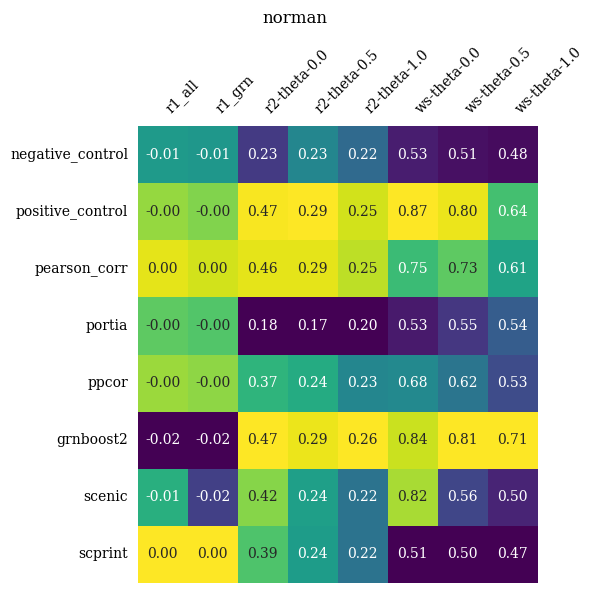

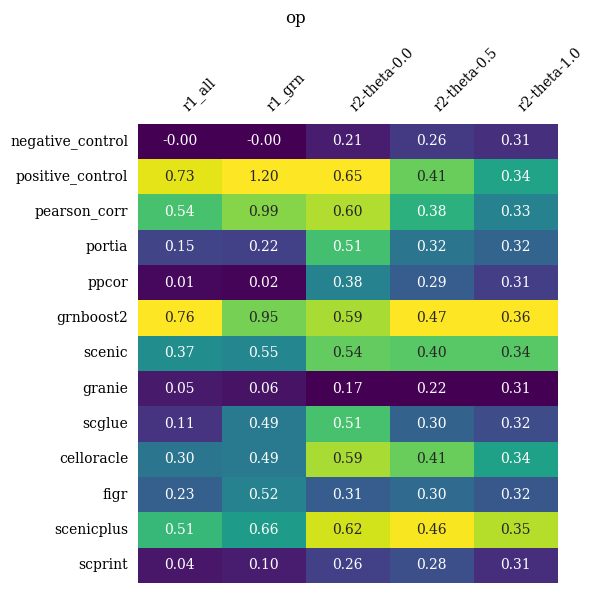

In [58]:
df_all = pd.read_csv('resources/scores/default_scores.csv', index_col=0).set_index('model')
df_scprint = pd.read_csv('resources/scores/scores_scprint.csv', index_col=0)

datasets = df_scprint['dataset'].unique()

for dataset in datasets:
    df_0 = df_all[df_all['dataset'] == dataset]
    df_0 = df_0.drop('dataset', axis=1)
    df_0 = df_0.dropna(axis=1, how='all')

    df_1 = df_scprint[df_scprint['dataset'] == dataset]
    df_1 = df_1.drop('dataset', axis=1)
    df_1 = df_1.dropna(axis=1, how='all')

    df = pd.concat([df_0, df_1], axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_heatmap(df, ax=ax, cmap='viridis')
    fig.suptitle(f'{dataset}')
    plt.tight_layout()
    plt.show()



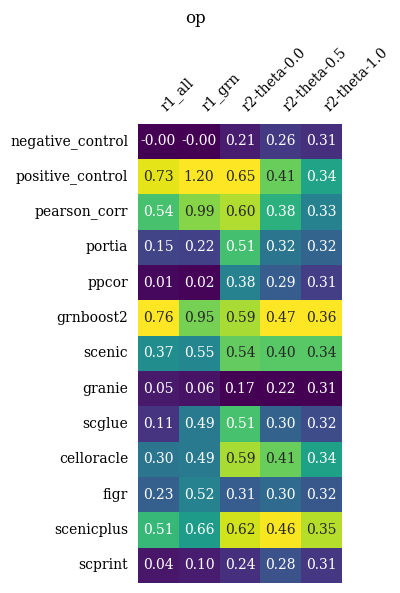

# Subsample

In [11]:
df = pd.read_csv(f'resources/scores/op/subsampled.csv', index_col=0)
df.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0
pearson_corr_1,0.530897,0.970276,0.568970,0.436350,0.367186
pearson_corr_2,0.532218,0.983027,0.583044,0.439533,0.368858


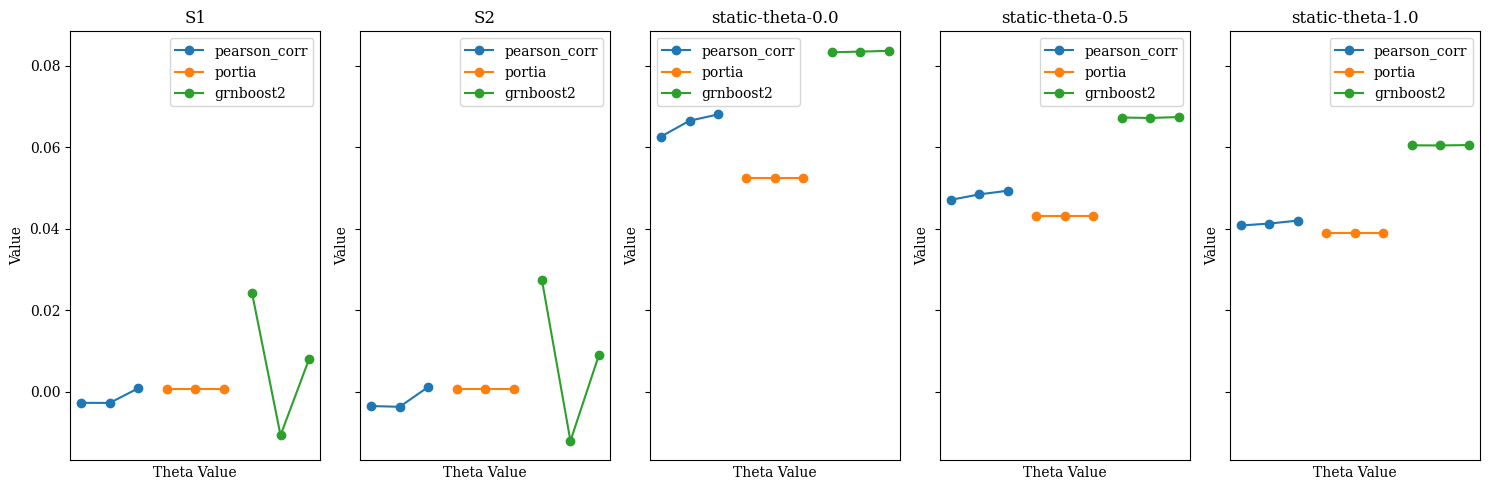

In [10]:

theta_values = [0.2, 0.5, 1.0]
methods = ['pearson_corr', 'portia', 'grnboost2']

# Prepare the figure with subplots (one for each column in df)
fig, axes = plt.subplots(1, len(df.columns), figsize=(15, 5), sharey=True)

# Loop through each column and plot
for i, col in enumerate(df.columns):
    ax = axes[i]
    
    # Plot each method's line for the current subplot
    for method in methods:
        # Filter out the rows that match the current method
        method_rows = df.index.str.contains(method)
        
        # Get the values corresponding to theta values (0.2, 0.5, 1.0)
        method_data = df.loc[method_rows, col]
        
        # Drop missing values (NaN) and plot
        method_data = method_data.dropna()
        
        # Plot only if there are available data points
        if len(method_data) > 0:
            ax.plot(method_data.index, method_data.values, marker='o', label=method)
    
    # Set labels and title for each subplot
    ax.set_title(f'{col}')
    ax.set_xlabel('Theta Value')
    ax.set_ylabel('Value')
    ax.set_xticks([])
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Prior 

In [7]:
if False: 
    create_skeleton() # create tf2gene putative links

# Run grn inference 

In [8]:
if False: # local runs
    run_grn_inference()

# Calculate scores

In [9]:
from src.helper import calculate_scores
if False: # consensus: run this after updating grns
    run_consensus(par)

if False: # run metrics/script_all.py
    calculate_scores()

# Regression scores

### OPSCA

#### Ridge

In [12]:
df_scores = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global_False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

FileNotFoundError: [Errno 2] No such file or directory: 'resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global_False.csv'

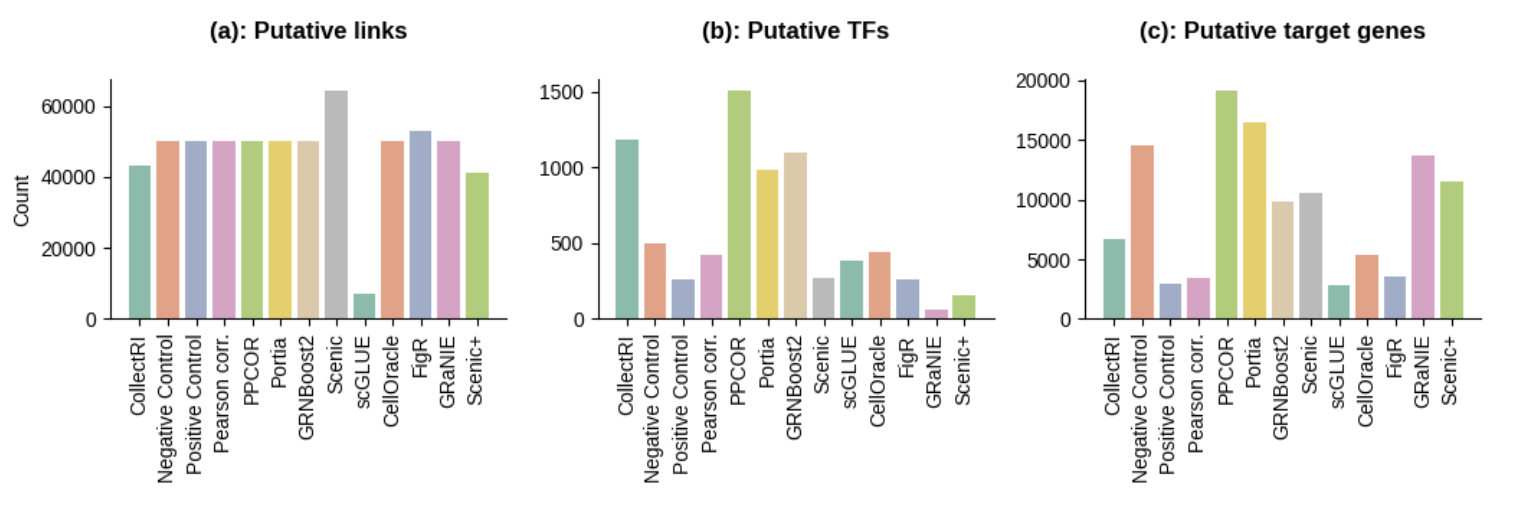

#### GB

In [3]:
df_scores = pd.read_csv(f"resources/scores/op/50000-skeleton_False-binarize_True-GB.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,0.037785,0.082205,0.282480,0.294742,11
negative_control,0.000440,0.000459,0.260926,0.302373,12
positive_control,0.671630,1.106263,0.739857,0.420285,1
pearson_corr,0.546758,1.005020,0.682991,0.396617,3
portia,0.317483,0.459731,0.595570,0.345240,7
ppcor,0.097117,0.117754,0.396929,0.306533,10
grnboost2,0.653354,0.819973,0.658351,0.493956,2
scenic,0.219697,0.325873,0.596756,0.441442,6
granie,0.084081,0.110564,0.172862,0.211528,13
scglue,0.105952,0.462190,0.581289,0.316301,9


### replogle2

In [6]:
df_scores = pd.read_csv(f"resources/scores/replogle2/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0

df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.007890,0.007940,0.004070,0.007549,0.016413,7
positive_control,0.014413,0.019584,0.070334,0.051472,0.043955,2
pearson_corr,-0.008077,-0.010913,0.068009,0.049308,0.041981,3
portia,0.005164,0.005206,0.052368,0.043075,0.039028,4
ppcor,-0.025308,-0.025607,0.007153,0.009689,0.017616,6
grnboost2,-0.007698,-0.008728,0.083347,0.067546,0.060886,1
scenic,0.005057,0.006892,0.031547,0.021333,0.023515,5


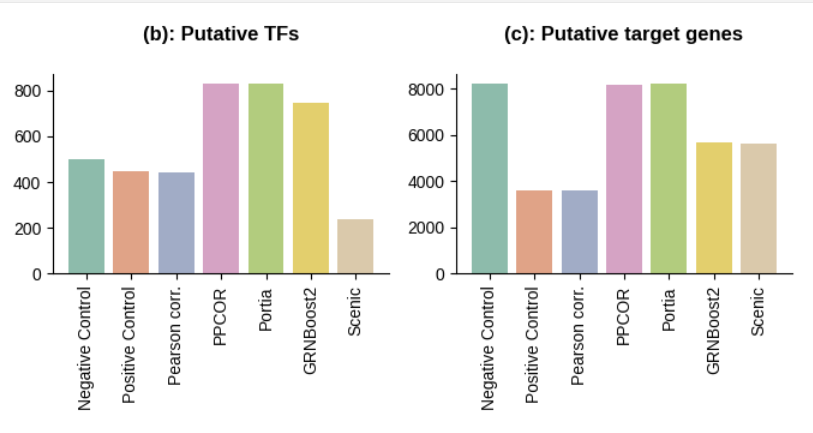

### nakatake

In [7]:
df_scores = pd.read_csv(f"resources/scores/nakatake/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000815,-0.000943,0.000648,0.024343,0.047426,7
positive_control,0.000333,0.000933,0.050172,0.195597,0.103299,1
pearson_corr,0.002183,0.006059,0.042007,0.177372,0.092215,3
portia,0.000026,0.001641,0.044538,0.094127,0.071015,4
ppcor,-0.000114,-0.000657,0.004380,0.028708,0.049842,6
grnboost2,-0.001190,-0.001845,0.023334,0.179273,0.144886,2
scenic,0.003915,0.006797,0.005719,0.078472,0.091197,5


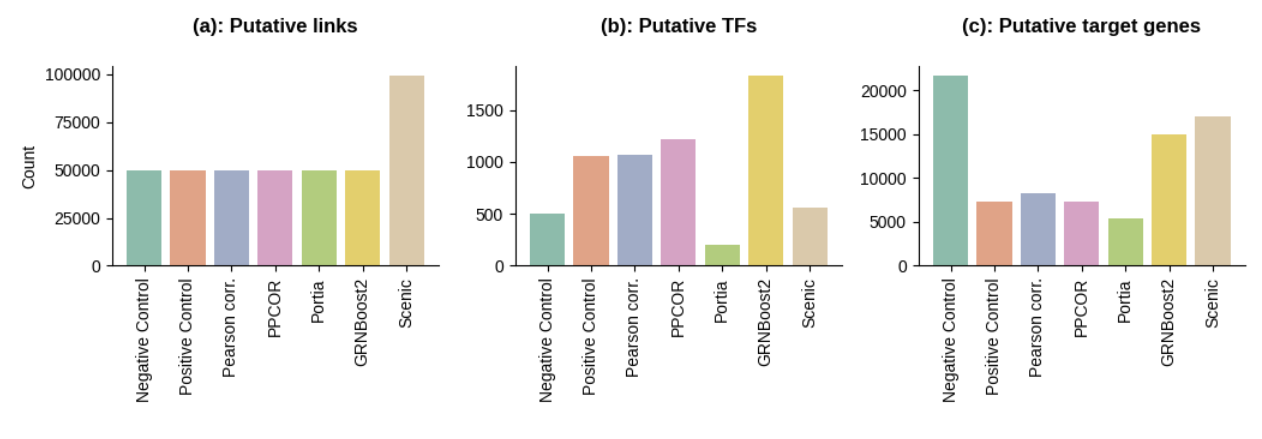

### norman 

In [8]:
df_scores = pd.read_csv(f"resources/scores/norman/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000234,-0.000256,0.014227,0.013110,0.003253,7
positive_control,-0.002901,-0.003470,0.136180,0.098129,0.040224,2
pearson_corr,0.001870,0.002176,0.135031,0.092110,0.036152,3
portia,-0.002051,-0.002247,0.064202,0.037832,0.009061,5
ppcor,0.001867,0.002047,0.093536,0.052257,0.011904,4
grnboost2,0.000263,0.000314,0.114651,0.101651,0.056132,1
scenic,0.001586,0.004122,0.084830,0.022496,0.005257,6


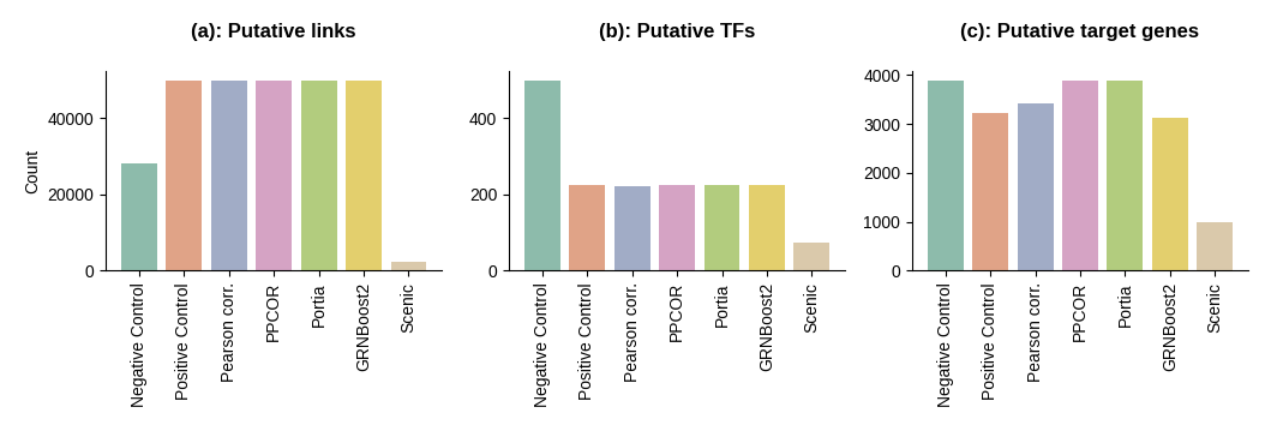

In [10]:
!ls resources/scores/adamson/

50000-skeleton_False-binarize_True-ridge.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv


### adamson

In [12]:
df_scores = pd.read_csv(f"resources/scores/adamson/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.022322,0.022322,0.445594,0.439009,0.413479,5
positive_control,-0.021639,-0.027437,0.664241,0.482923,0.436312,2
pearson_corr,0.024375,0.030097,0.652753,0.481473,0.435883,3
portia,-0.022940,-0.023618,0.341579,0.371780,0.401550,6
ppcor,-0.017781,-0.017927,0.555375,0.453831,0.423552,4
grnboost2,-0.011154,-0.013385,0.679135,0.503771,0.451201,1


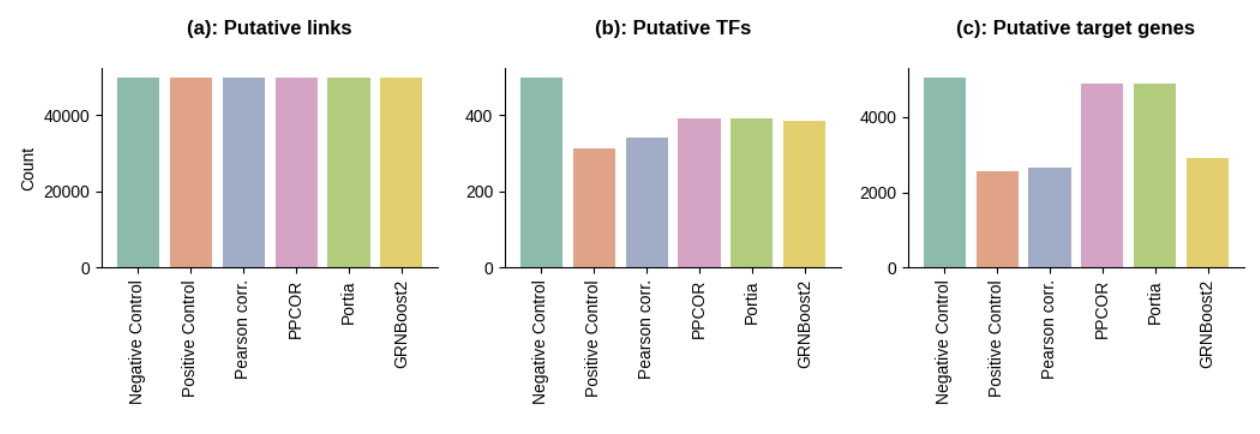

### Global models

In [119]:
!ls resources/scores/op/

50000-skeleton_False-binarize_True-GB.csv
50000-skeleton_False-binarize_True-ridge.csv
lognorm-50000-skeleton_False-binarize_True-ridge-global-False.csv
nets
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv


In [121]:
df_scores_gb = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv", index_col=0)
df_scores = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)

df_scores = pd.concat([df_scores, df_scores_gb])
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
collectri,0.058315,0.126899,0.229779,0.272409,0.290769,13
negative_control,-0.000923,-0.000961,0.193640,0.260667,0.290877,19
positive_control,0.721750,1.188803,0.654297,0.411675,0.310124,2
pearson_corr,0.570333,1.048355,0.580583,0.379891,0.303594,4
portia,0.465527,0.674097,0.513885,0.317206,0.298095,7
ppcor,0.196689,0.238486,0.362190,0.289743,0.291190,10
grnboost2,0.735540,0.923076,0.581265,0.471491,0.329940,1
scenic,0.318873,0.467008,0.519103,0.406525,0.317489,6
granie,0.147522,0.193977,0.165400,0.211497,0.283239,21
scglue,0.155642,0.678908,0.499250,0.293863,0.293939,8


# Robustness analysis

In [25]:
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh # !python src/robustness_analysis/script_all.py
base_dir = 'resources/results/robustness_analysis'

Submitted batch job 7770049


In [26]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

## Permute net

In [27]:
# net 
noise_type = 'net'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [28]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132838,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063194,-0.037703,0.258300,0.201382,0.094161,-0.016007,0.246858,0.117373,0.052529,0.046615,0.159076,0.085768,0.259247
20,-0.068023,-0.038826,0.232850,0.188608,0.076579,-0.025485,0.213148,0.103506,0.043782,0.037751,0.145942,0.079237,0.243952
50,-0.075000,-0.037746,0.182995,0.174772,0.020020,0.005844,0.099969,0.057258,0.005112,-0.019924,0.099687,0.052120,0.147341
100,-0.084617,-0.038591,-0.009365,-0.045844,-0.052908,-0.064681,-0.057610,-0.016075,-0.004035,-0.045894,-0.019244,-0.013468,-0.006252


In [29]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.337533,0.316130,0.501373,0.447392,0.268367,0.335675,0.467258,0.354542,0.514954
10,0.310607,0.300799,0.433080,0.427072,0.337533,0.314340,0.492975,0.439982,0.263060,0.334209,0.453522,0.356273,0.506758
20,0.312346,0.298023,0.428219,0.416558,0.334752,0.307381,0.481193,0.427551,0.268367,0.330640,0.444836,0.351414,0.498718
50,0.305605,0.301245,0.413182,0.397406,0.322203,0.301887,0.442722,0.399035,0.288905,0.320246,0.407539,0.344040,0.464195
100,0.295797,0.303241,0.379001,0.345088,0.291961,0.286424,0.293421,0.317192,0.318627,0.289704,0.310580,0.316354,0.321514


## Permute sign

In [30]:
noise_type = 'sign'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [31]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063294,-0.037943,0.244253,0.175927,0.068840,-0.026427,0.225111,0.097068,0.043191,0.039099,0.130693,0.066178,0.232978
20,-0.078692,-0.037331,0.195138,0.143907,0.030350,-0.041580,0.162380,0.059698,0.023835,0.021276,0.078184,0.049052,0.183118
50,-0.080401,-0.034971,-0.016077,0.001196,-0.000673,0.006405,-0.085877,-0.047863,0.000526,-0.019741,0.010997,-0.007829,-0.006821
100,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561


In [32]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257013,0.335675,0.467258,0.354542,0.514954
10,0.315233,0.298546,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257063,0.335675,0.467258,0.354542,0.514954
20,0.315206,0.298645,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256943,0.335675,0.467258,0.354542,0.514954
50,0.315729,0.299033,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256891,0.335675,0.467258,0.354542,0.514954
100,0.314412,0.298592,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257129,0.335675,0.467258,0.354542,0.514954


## Permute weight

In [33]:
noise_type = 'weight'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

# Effect of pseudobulking on performance

In [2]:
from src.helper import analyse_meta_cells
analyse_meta_cells(task_grn_inference_dir='./')

# Effect of imputation on performance

In [ ]:
from src.helper import analyse_imputation
analyse_imputation(task_grn_inference_dir='./')

# Causal versus correlations

In [14]:
from src.helper import analyse_causal
analyse_causal(task_grn_inference_dir='./')


convert to long dataframe
TF subsetting
(456, 25090)
----cross validate for default----


Processing groups: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
GRN preprocessing: 25090it [00:00, 25373.48it/s]
ridge CV: 100%|██████████| 25090/25090 [00:02<00:00, 11765.42it/s]
GRN preprocessing: 25090it [00:00, 25339.89it/s]
ridge CV: 100%|██████████| 25090/25090 [01:55<00:00, 217.99it/s]

Static approach (theta=1):



GRN preprocessing: 25090it [00:00, 25640.46it/s]
ridge CV: 100%|██████████| 25090/25090 [06:10<00:00, 67.69it/s]


convert to long dataframe
(456, 25090)
----cross validate for default----


Processing groups: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
GRN preprocessing: 25090it [00:11, 2215.38it/s]
ridge CV: 100%|██████████| 25090/25090 [00:02<00:00, 9352.85it/s] 
GRN preprocessing: 25090it [00:11, 2211.47it/s]
ridge CV: 100%|██████████| 25090/25090 [02:10<00:00, 191.63it/s]


Static approach (theta=1):


GRN preprocessing: 25090it [00:11, 2197.01it/s]
ridge CV:  21%|██        | 5145/25090 [01:17<05:00, 66.47it/s]

array(['ZNF354C', 'KLF12', 'ZNF143', ..., 'ZNF831', 'ZRSR2', 'ZSWIM1'],
      dtype='<U14')